# Extract Image Drawing
This notebook uses the CSV outputs from the template ROI and drawing ROI processing, and produces an image containing only the drawing after removing the template, centering around the drawing coordinates and denoising the result.

In [1]:
%matplotlib inline

import math
from pathlib import Path

import cv2
import skimage
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from bananas.utils import images 

# Root path of project relative to this notebook
ROOT = Path('..')

sys.path.insert(1, str(ROOT / 'scripts'))
from datamodels import *
from utils import *

### Load data from sources and join it into a single table

In [2]:
# Read and merge data sources
df_tpl = pd.read_csv(ROOT / 'datasets' / 'template_roi.csv').set_index('image_path')
df_drawing = pd.read_csv(ROOT / 'datasets' / 'drawing_roi.csv').set_index('image_path')
df = pd.merge(df_tpl, df_drawing, left_index=True, right_index=True, how='inner')

# Convert non-primitive fields
df['drawing_box'] = df['drawing_box'].apply(lambda x: Box.load(x))
df['template_box'] = df['template_box'].apply(lambda x: Box.load(x))

df.head()

,template_name,template_path,template_box,drawing_box
image_path,,,,
drawings/CASA/casaPsic_025Ev4.pdf_pg-12.jpg,casa,templates/casa.png,"254,67,420,264","36,8,284,302"
drawings/CASA/casaPsic_135Ev2.pdf_pg-10.jpg,casa,templates/casa.png,"250,88,416,285","3,29,251,323"
drawings/CASA/casaPsic_004Ev4.pdf_pg-13.jpg,casa,templates/casa.png,"248,8,414,205","142,187,390,444"
drawings/CASA/casaPsic_220Ev3.pdf_pg-8.jpg,casa,templates/casa.png,"197,90,363,287","317,38,565,332"
drawings/CASA/casaPsic_029Ev3.pdf_pg-8.jpg,casa,templates/casa.png,"264,114,430,311","74,50,322,344"


### Helper functions

In [3]:
# https://stackoverflow.com/a/51174313/440780
def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                      for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))


In [4]:
def process_tpl(tpl: Template) -> np.ndarray:
    
    # Smooth over template
    kernel_size = 9
    kernel = np.ones((kernel_size, kernel_size), dtype=np.float32) / kernel_size ** 2
    tpl = cv2.filter2D(tpl.image, -1, kernel)

    # Darken smooth template
    return adjust_gamma(tpl, gamma=.05).astype(np.float32)

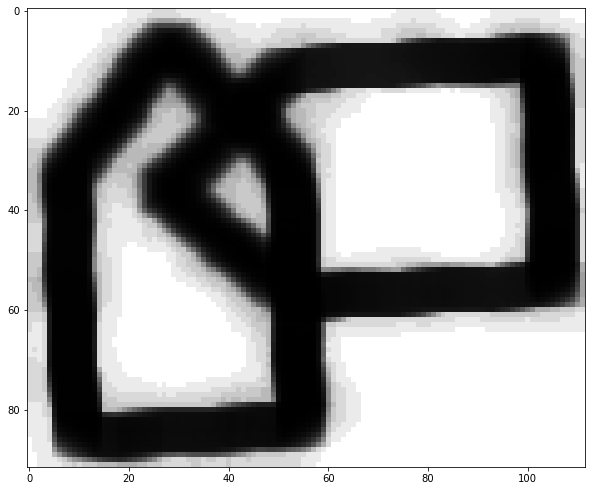

In [5]:
templates = tpl_load_all(ROOT / 'templates')
tpl = templates[2]

tpl_smooth = process_tpl(tpl)
imshow(tpl_smooth)

In [6]:
def del_tpl(img: np.ndarray, tpl: np.ndarray, roi: Box):
    
    # Convert drawing to floating type to prevent overflow
    img = img.astype(np.float32)

    # Within the bounding box, erase template
    patch = img[roi.top:roi.bottom, roi.left:roi.right] + (255 - tpl)
    img[roi.top:roi.bottom, roi.left:roi.right] = np.clip(patch, 0 , 255)

    # Convert image back to uint8
    return img.astype(np.uint8)

def del_noise(img: np.ndarray):
    
    # Remove noise from image
    img_denoised = cv2.fastNlMeansDenoising(img)
    
    # Binarized result
    _, img_denoised = cv2.threshold(img_denoised, 0, 255, cv2.THRESH_OTSU)
    return img_denoised

def inverse(img):
    return 255 - img

def binarize(img, blksize=35, C=3):
    '''
    Image preprocessing function that converts an image into B/W using adaptive thresholding.
    '''
    return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, blksize, C)

def delete_small_components(img, threshold=56):
    '''
    Image preprocessing function that computes connected components and deletes
    those below a certain thershold of number of pixels. Input image must be binarized.
    '''

    # Enumerate the connected components
    num, traces = cv2.connectedComponents(img)
    for i in range(1, num):

        # Remove small connected components which are likely just noise
        ct = len(traces[traces == i])
        if ct < threshold:
            traces[traces == i] = 0

    traces[traces != 0] = img.max()
    return traces

def center_drawing(img, atol=1E-3):
    '''
    Image preprocessing function that removes all empty whitespace around drawing.
    '''

    # Remove the top N columns that are empty, and rotate the drawing
    # Doing this 4 times effectively removes whitespace in all 4 directions
    for _ in range(4):
        row_curr = 0
        while abs(img[row_curr].min() - img[row_curr].max()) < atol:
            row_curr += 1
            if len(img) >= row_curr: break
        img = img[row_curr-1:, :]
        img = np.rot90(img)

    return img

def resize_output(img, side=300, fill_color=0):
    delta_y = side - img.shape[0]
    delta_x = side - img.shape[1]
    padding_y = math.floor(delta_y / 2), math.ceil(delta_y / 2)
    padding_x = math.floor(delta_x / 2), math.ceil(delta_x / 2)
    squared = np.ones((side, side), dtype=img.dtype) * fill_color
    squared[padding_y[0]:-padding_y[1], padding_x[0]:-padding_x[1]] = img
    return squared


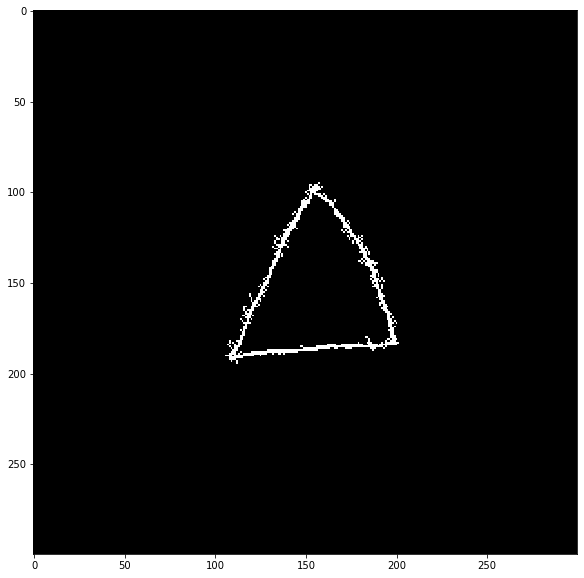

In [7]:
# Make sure output directory exists
out_dir = ROOT / 'processed'
out_dir.mkdir(exist_ok=True)

# Save all processed output paths into a list of records
processed_records = []

# Iterate over each image
for image_path, record in tqdm(df.iterrows(), total=len(df)):
    
    # Open image
    img = images.open_image(ROOT / image_path, convert='L')
    
    # Get the corresponding template
    tpl = [tpl for tpl in templates if tpl.name == record['template_name']][0]
    
    # Remove template from image
    img = del_tpl(img, process_tpl(tpl), record['template_box'])
    
    # Extract drawing from page
    drawing_box = record['drawing_box']
    img = img[drawing_box.top:drawing_box.bottom, drawing_box.left:drawing_box.right]
    
    # Process drawing to remove noise
    img = binarize(img)
    img = inverse(img)
    img = del_noise(img)
    img = delete_small_components(img)
    
    # Resize image to consistent 300x300
    img = images.resize_canvas(img, 300, 300, fill_color_rgb=(0, 0, 0))
    
    # Write processed output
    out_path = out_dir / Path(image_path).name
    images.ndarray_to_pil(img.astype(np.uint8)).convert('L').save(str(out_path))
    
    # Save it as a record
    processed_records.append({
        'image_path': image_path,
        'processed_path': out_path.relative_to(ROOT)})
    
df_processed = pd.DataFrame.from_records(processed_records).set_index('image_path')
pd.merge(df, df_processed, left_index=True, right_index=True, how='inner').to_csv(ROOT / 'datasets' / 'image_processed.csv')
imshow(img)